In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 5

mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)



Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,16,3,padding=1),                            # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,32,3,padding=1),                           # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),                           # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)                                       # batch x 64 x 14 x 14
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),                          # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),                         # batch x 64 x 7 x 7
                        nn.ReLU()
        )
        
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1),                    # batch x 128 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),                       # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,16,3,1,1),                        # batch x 16 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,1,3,2,1,1),                       # batch x 1 x 28 x 28
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = x.view(batch_size,256,7,7)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

encoder = Encoder().to(device)
decoder = Decoder().to(device)


parameters = list(encoder.parameters())+ list(decoder.parameters())

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

cuda:0


In [ ]:
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        optimizer.zero_grad()
        image = image.to(device)
        
        output = encoder(image)
        output = decoder(output)
        
        loss = loss_func(output,image)
        loss.backward()
        optimizer.step()

        if j % 100 == 0:
          print(loss)

tensor(0.4193, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0464, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0411, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0374, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0319, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0324, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0317, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0241, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0243, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0235, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0227, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0226, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0230, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0232, device='cuda:0', grad_fn=<MseLossBackward>)


torch.Size([256, 28, 28])


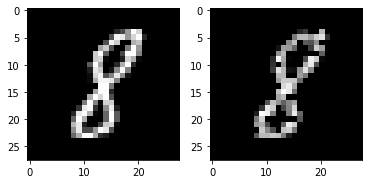

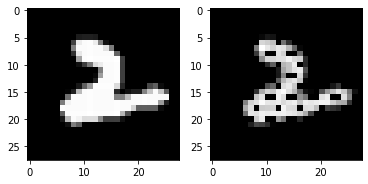

In [ ]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(2):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(image[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()